In [1]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Currently, memory growth needs to be the same across GPUs
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# Load Data

In [3]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split the training data into responses and predictors.

In [6]:
train_y = np.array(train_data.iloc[:, 0], dtype='uint8')
train_x = train_data.drop(axis=1, labels='label')

Regularize the pixel values.

In [7]:
train_x  = train_x / 255
test_x = test_data / 255

Reshape the predictors into 28x28 arrays to feed into the model. Since there is only one monochrome channel, the shape will be 28x28x1.

In [8]:
train_x = train_x.values.reshape(-1, 28, 28, 1)
test_x = test_x.values.reshape(-1, 28, 28, 1)

Plot one of the inputs to see how it looks:

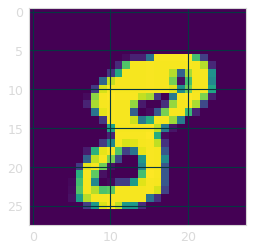

In [9]:
plt.imshow(train_x[10].squeeze())

The data can be augmented at runtime using the Keras ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range=0.15)

# Model

Build up a model using the TF Keras functional API.

In [11]:
inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Conv2D(64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Conv2D(128, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Conv2D(256, kernel_size=2, activation='relu', )(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# x = Conv2D(128, kernel_size=2, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train

In [12]:
train_x_split, val_x_split, train_y_split, val_y_split = model_selection.train_test_split(train_x, train_y, test_size = 0.1)

In [13]:
EPOCHS = 45
BATCH_SIZE = 64

model.fit_generator(
    datagen.flow(train_x_split, train_y_split, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_x_split) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_x_split, val_y_split))

Epoch 1/45
590/590 [==============================] - 35s 58ms/step - loss: 0.8934 - accuracy: 0.7122 - val_loss: 0.3209 - val_accuracy: 0.9062
Epoch 2/45
590/590 [==============================] - 33s 55ms/step - loss: 0.2475 - accuracy: 0.9279 - val_loss: 0.0549 - val_accuracy: 0.9817
Epoch 3/45
590/590 [==============================] - 32s 55ms/step - loss: 0.1832 - accuracy: 0.9459 - val_loss: 0.0625 - val_accuracy: 0.9848
Epoch 4/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1456 - accuracy: 0.9587 - val_loss: 0.0576 - val_accuracy: 0.9855
Epoch 5/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1264 - accuracy: 0.9635 - val_loss: 0.0396 - val_accuracy: 0.9895
Epoch 6/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1172 - accuracy: 0.9670 - val_loss: 0.0511 - val_accuracy: 0.9862
Epoch 7/45
590/590 [==============================] - 33s 55ms/step - loss: 0.1095 - accuracy: 0.9701 - val_loss: 0.0416 - val_accuracy:

In [14]:
predictions = pd.Series(np.argmax(model.predict(test_x), axis=1), name='Label')
image_id = pd.Series(np.arange(1, len(test_x) + 1), name='ImageId')

submit = pd.concat([image_id, predictions], axis=1)
submit.to_csv('digit_pred.csv', index=False)